<div style="
    background:#ff4da6;
    color:white;
    padding:14px 20px;
    border-radius:12px;
    font-weight:700;
    display:block;
    font-size:18px;
    text-align:center;
    max-width:700px;
    margin:auto;
">
✨ Hello everyone, ✨<br><br>
This notebook presents my implementation of a Pix2Pix-based GAN model.<br>
It includes data preprocessing, model architecture (Generator & Discriminator), training loops, and evaluation functions.<br>
Training was completed successfully, and the notebook is organized so you can easily test different hyperparameters, loss weights, and model settings.<br><br>
🚀 Feel free to explore, modify, and experiment with the code.
</div>



In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/101_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/4_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/26_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/162_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/119_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/72_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/34_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/163_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/47_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/68_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/138_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/177_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/183_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/161_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import time

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Conv2D, Input, MaxPool2D, Conv2DTranspose, concatenate, Lambda, BatchNormalization, Activation, LeakyReLU, ReLU
from keras.utils import img_to_array, load_img, plot_model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.layers import Dropout

from tensorflow.keras import Sequential  # تغییر به tf.keras

from tensorflow.keras.layers import ZeroPadding2D

from tensorflow.keras.initializers import RandomNormal  # اصلاح: از tf.keras.initializers وارد کنید




path = "../input/pix2pix-dataset/maps/maps/train/"
num_images = 1000  # یا len(all_files) برای همه
print("TensorFlow is working:", tf.__version__)

2025-11-23 11:13:42.264842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763896422.426312      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763896422.474457      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow is working: 2.18.0


<div style="background:#ff4da6; color:white; padding:10px 16px; border-radius:8px; font-weight:700; display:inline-block; font-size:18px;">
  augmentation 

</div>

Found 1000 images
First 5 images: ['../input/pix2pix-dataset/maps/maps/train/623.jpg', '../input/pix2pix-dataset/maps/maps/train/764.jpg', '../input/pix2pix-dataset/maps/maps/train/1075.jpg', '../input/pix2pix-dataset/maps/maps/train/771.jpg', '../input/pix2pix-dataset/maps/maps/train/208.jpg']


I0000 00:00:1763896440.720781      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763896440.721450      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


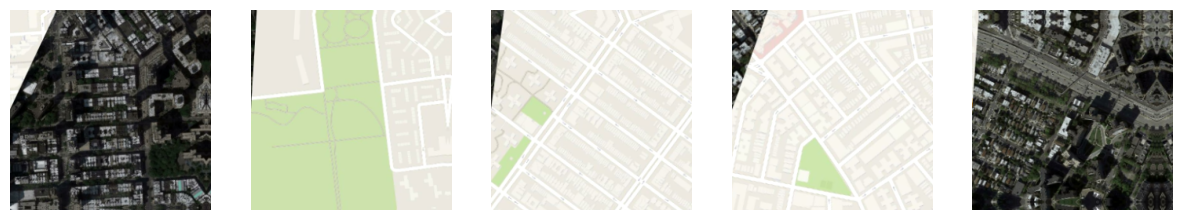

In [5]:
# List of files
all_files = glob(os.path.join(path, "*.jpg")) + glob(os.path.join(path, "*.png"))
image_files = all_files[:num_images]


print(f"Found {len(image_files)} images")
print("First 5 images:", image_files[:5])


# Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])


# ================================
   # Image processing function
# ================================
def process_image(file_path):

    # load
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # split
    w = tf.shape(image)[1] // 2
    real_image = image[:, w:, :]
    input_image = image[:, :w, :]

    # resize
    input_image = tf.image.resize(input_image, [256, 256])
    real_image  = tf.image.resize(real_image,  [256, 256])

    # join for augmentation
    stacked = tf.concat([input_image, real_image], axis=1)
    stacked = data_augmentation(stacked)

    # split again
    input_image = stacked[:, :256, :]
    real_image  = stacked[:, 256:, :]

    # normalize [-1,1]
    input_image = (tf.cast(input_image, tf.float32) / 127.5) - 1
    real_image  = (tf.cast(real_image, tf.float32) / 127.5) - 1

    return (input_image, real_image)



# ================================
#     Dataset
# ================================
dataset = tf.data.Dataset.from_tensor_slices(image_files)
dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

dataset = (
    dataset.shuffle(1000)
           .batch(32)
           .prefetch(tf.data.AUTOTUNE)
)



# ================================
#     Test batch
# ================================
for input_batch, real_batch in dataset.take(1):
    plt.figure(figsize=(15, 5))
    for i in range(min(5, real_batch.shape[0])):
        img = (real_batch[i] + 1) / 2
        plt.subplot(1, 5, i + 1)
        plt.imshow(img.numpy())
        plt.axis('off')
    plt.show()


<div style="background:#ff4da6; color:white; padding:10px 16px; border-radius:8px; font-weight:700; display:inline-block; font-size:18px;">
  Pix2Pix Model
</div>



<div style="background:#ff4da6; color:white; padding:10px 16px; border-radius:8px; font-weight:700; display:inline-block; font-size:18px;">
 generator (U-Net architecture)
</div>


In [6]:

def build_generator(image_shape=(256, 256, 3)):
    def downsample(filters, size, apply_batchnorm=True):
        init = RandomNormal(stddev=0.02)
        layer = Sequential()
        layer.add(Conv2D(filters, size, strides=2, padding='same', kernel_initializer=init, use_bias=False))
        if apply_batchnorm:
            layer.add(BatchNormalization())
        layer.add(LeakyReLU())
        return layer
    
    def upsample(filters, size, apply_dropout=False):
        init = RandomNormal(stddev=0.02)
        layer = Sequential()
        layer.add(Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=init, use_bias=False))
        layer.add(BatchNormalization())
        if apply_dropout:
            layer.add(Dropout(0.5))
        layer.add(ReLU())
        return layer
    
    inputs = Input(shape=image_shape)
    
    # Encoder (downsampling)
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    
    # Decoder (upsampling)
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 512)
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    
    init = RandomNormal(stddev=0.02)
    last = Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=init, activation='tanh')
    
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concatenate([x, skip])
    
    x = last(x)
    return Model(inputs=inputs, outputs=x)

generator = build_generator(image_shape=(256, 256, 3))



<div style="background:#ff4da6; color:white; padding:10px 16px; border-radius:8px; font-weight:700; display:inline-block; font-size:18px;">
 discriminator (PatchGAN)</div>


In [7]:
def build_discriminator(image_shape=(256, 256, 3)):
    init = RandomNormal(stddev=0.02)
    inp = Input(shape=image_shape, name='input_image')
    tar = Input(shape=image_shape, name='target_image')

    
    x = concatenate([inp, tar])  # (bs, 256, 256, 6)
    
    down1 = Conv2D(64, 4, strides=2, padding='same', kernel_initializer=init)(x)
    down1 = LeakyReLU()(down1)
    
    down2 = Conv2D(128, 4, strides=2, padding='same', kernel_initializer=init)(down1)
    down2 = BatchNormalization()(down2)
    down2 = LeakyReLU()(down2)
    
    down3 = Conv2D(256, 4, strides=2, padding='same', kernel_initializer=init)(down2)
    down3 = BatchNormalization()(down3)
    down3 = LeakyReLU()(down3)
    
    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(512, 4, strides=1, kernel_initializer=init, use_bias=False)(zero_pad1)
    batchnorm1 = BatchNormalization()(conv)
    leaky_relu = LeakyReLU()(batchnorm1)
    
    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides=1, kernel_initializer=init)(zero_pad2)
    
    return Model(inputs=[inp, tar], outputs=last)

# Test building the model (to check for errors)
discriminator = build_discriminator()
print(discriminator.summary())  
discriminator = build_discriminator(image_shape=(256, 256, 3))


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │      6,208 │ concatenate_7[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 128, 128,  │          0 │ conv2d_8[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    131,200 │ leaky_re_lu_8[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │    524,544 │ leaky_re_lu_9[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_10      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 34, 34,    │          0 │ leaky_re_lu_10[0… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 31, 31,    │  2,097,152 │ zero_padding2d[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_11      │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 33, 33,    │          0 │ leaky_re_lu_11[0… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 30, 30, 1) │      8,193 │ zero_padding2d_1

 Total params: 2,770,881 (10.57 MB)

 Trainable params: 2,769,089 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

None





<div style="background:#ff4da6; color:white; padding:10px 16px; border-radius:8px; font-weight:700; display:inline-block; font-size:18px;">
 Optimizer
    (Optimizers) , (Loss Functions)</div>

In [8]:
# optimizer

generator_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_optimizer = Adam(2e-4, beta_1=0.5)

# lossها
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return gan_loss + (100 * l1_loss)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(disc_generated_output), disc_generated_output)
    return (real_loss + generated_loss) / 2



<div style="background:#ff4da6; color:white; padding:10px 16px; border-radius:8px; font-weight:700; display:inline-block; font-size:18px;">
Train Step</div>

In [9]:
# train step
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))


<div style="background:#ff4da6; color:white; padding:10px 16px; border-radius:8px; font-weight:700; display:inline-block; font-size:18px;">
Train Loop
</div>

In [12]:
import os

# مسیر دایرکتوری تصاویر
dataset_dir = "../input/pix2pix-dataset/maps/maps/train"

# جمع‌آوری مسیر همه تصاویر
image_paths = []
for filename in os.listdir(dataset_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_paths.append(os.path.join(dataset_dir, filename))

# نمایش تعداد تصاویر
print(f"Found {len(image_paths)} images")

# نمایش 4 نمونه اول
print("First 4 samples:", image_paths[:4])


Found 1096 images
First 4 samples: ['../input/pix2pix-dataset/maps/maps/train/623.jpg', '../input/pix2pix-dataset/maps/maps/train/764.jpg', '../input/pix2pix-dataset/maps/maps/train/1075.jpg', '../input/pix2pix-dataset/maps/maps/train/771.jpg']


In [15]:
import tensorflow as tf

# تعداد تصاویر در هر batch
batch_size = 32

# فرض: image_paths آماده است و process_image تعریف شده
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [35]:
# Training loop with epochs
epochs = 10  # 
for epoch in range(epochs):
    start = time.time()
    print(f"Epoch {epoch+1}/{epochs}")
    for input_image, target in dataset:
        train_step(input_image, target)
    print(f"Time for epoch {epoch+1}: {time.time() - start} sec")

Epoch 1/10
Time for epoch 1: 50.582157373428345 sec
Epoch 2/10
Time for epoch 2: 51.92395567893982 sec
Epoch 3/10
Time for epoch 3: 53.03431487083435 sec
Epoch 4/10
Time for epoch 4: 52.98100161552429 sec
Epoch 5/10
Time for epoch 5: 52.78393483161926 sec
Epoch 6/10
Time for epoch 6: 52.77737998962402 sec
Epoch 7/10
Time for epoch 7: 53.06580209732056 sec
Epoch 8/10
Time for epoch 8: 53.0526168346405 sec
Epoch 9/10
Time for epoch 9: 53.13670229911804 sec
Epoch 10/10
Time for epoch 10: 53.01443147659302 sec




<div style="background:#ff4da6; color:white; padding:10px 16px; border-radius:8px; font-weight:700; display:inline-block; font-size:18px;">
Evaluation 

    
</div>


In [36]:
generator.save("/kaggle/working/generator_final.keras")
discriminator.save("/kaggle/working/discriminator_final.keras")


In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# لیست خالی برای ذخیره مسیرها
image_paths = []

# حلقه os.walk (بدون print داخل حلقه)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        image_paths.append(os.path.join(dirname, filename))

# فقط ۴ تا سمپل اول رو print کنید (برای چک کردن بدون خروجی زیاد)
print("First 4 image paths:")
for path in image_paths[:4]:
    print(path)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

First 4 image paths:
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/101_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/4_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/26_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/162_AB.jpg


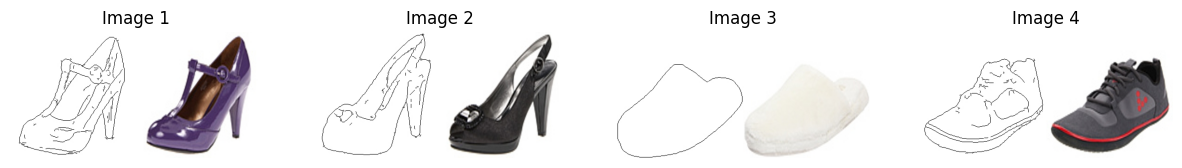

In [39]:
import matplotlib.pyplot as plt
from PIL import Image

# ۴ مسیر اول (از خروجی‌تون)
paths = [
    "/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/101_AB.jpg",
    "/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/4_AB.jpg",
    "/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/26_AB.jpg",
    "/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/162_AB.jpg"
]

# نمایش عکس‌ها
plt.figure(figsize=(15, 10))
for i, path in enumerate(paths):
    img = Image.open(path)
    plt.subplot(1, 4, i + 1)
    plt.title(f"Image {i+1}")
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [43]:
import os

for dirname, _, filenames in os.walk('/kaggle/input/pix2pix-dataset/maps'):
    print("DIR:", dirname)
    for filename in filenames[:5]:
        print("   -", filename)


DIR: /kaggle/input/pix2pix-dataset/maps
DIR: /kaggle/input/pix2pix-dataset/maps/maps
DIR: /kaggle/input/pix2pix-dataset/maps/maps/val
   - 623.jpg
   - 764.jpg
   - 1075.jpg
   - 771.jpg
   - 208.jpg
DIR: /kaggle/input/pix2pix-dataset/maps/maps/train
   - 623.jpg
   - 764.jpg
   - 1075.jpg
   - 771.jpg
   - 208.jpg


Total MAPS images: 1096
First 4 sample paths:
/kaggle/input/pix2pix-dataset/maps/maps/train/1.jpg
/kaggle/input/pix2pix-dataset/maps/maps/train/10.jpg
/kaggle/input/pix2pix-dataset/maps/maps/train/100.jpg
/kaggle/input/pix2pix-dataset/maps/maps/train/1000.jpg


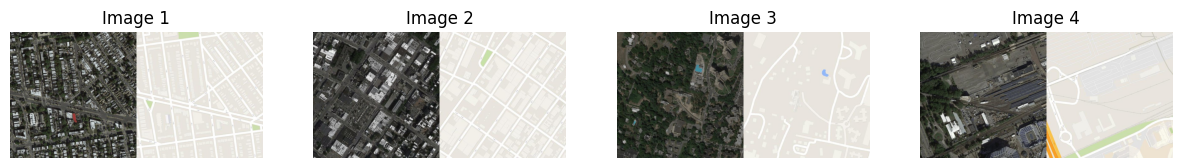

In [44]:
import glob
import matplotlib.pyplot as plt
from PIL import Image

# مسیر درست تصاویر train
paths = sorted(glob.glob("/kaggle/input/pix2pix-dataset/maps/maps/train/*.jpg"))

print("Total MAPS images:", len(paths))
print("First 4 sample paths:")
for p in paths[:4]:
    print(p)

# نمایش ۴ تصویر اول
plt.figure(figsize=(15, 5))
for i, path in enumerate(paths[:4]):
    img = Image.open(path)
    plt.subplot(1, 4, i+1)
    plt.title(f"Image {i+1}")
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [47]:
# ذخیره مدل Generator با فرمت جدید Keras
generator.save("/kaggle/working/generator_final.keras")

# ذخیره مدل Discriminator با فرمت جدید Keras
discriminator.save("/kaggle/working/discriminator_final.keras")
